# Кластеризация ЕГЭ (8.5 если сделаны все задачи)

Рядом лежат экселевские таблицы с координатами точек. В 3 и 4 задаче используется манхетеское расстояние. В остальных Евклидово.

* Постройте Распределение точек
* Кластеризуйте руками
* Постройте Распределение точек, отметьте принадлежность кластеров цветами
* Найдите среди в каждом кластере точку расстояние от которой до всех остальных минимально
* Выведите усреднение центров всех кластеров * 1000

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Кластеризация (0.75 за каждый алгоритм на всех данных)

На предложенных распределениях данных проверьте предложенные алгоритмы. Постройте графики кластеризации для каждой пары алгоритм-данные, разные кластеры покрасьте разным цветом. Воспользуйтесь sklearn реализациями. Параметры кластеризации для разных алгоритмов подберите такие, чтобы алгоритмы можно было сравнивать (по возможности одинаковое количество кластеров и т.д.)

In [61]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from itertools import cycle, islice

In [62]:
# # two_means =  
# # dbscan = 

# clustering_algorithms = (
#         ("MiniBatch\nKMeans", two_means),
#         ("DBSCAN", dbscan),
#     )


Dataset 0
Cluster 0
Medoid: [ 0.82110773 -0.89928032]
Center: [ 0.88465206 -0.89277022]
Cluster 1
Medoid: [-0.96237777  1.25283073]
Center: [-0.97019038  1.29018136]
Cluster 2
Medoid: [-0.79165176  0.44396744]
Center: [-0.77578511  0.38697422]
Average centers * 1000: [-287.10780937  261.4617872 ]

Dataset 1
Cluster 0
Medoid: [1.166348   0.26869586]
Center: [1.16352859 0.27919331]
Cluster 1
Medoid: [-0.09349962 -1.2117287 ]
Center: [-0.09948975 -1.21398629]
Cluster 2
Medoid: [-1.09128814  0.93308954]
Center: [-1.06403884  0.93479298]
Average centers * 1000: [6.66133815e-13 1.29526020e-12]

Dataset 2
Cluster 0
Medoid: [-0.97533681  0.93382697]
Center: [-0.93940052  0.92411963]
Cluster 1
Medoid: [ 0.84988233 -1.23688163]
Center: [ 0.82007567 -1.25222201]
Cluster 2
Medoid: [ 0.89255472 -0.47092914]
Center: [ 0.88208918 -0.43565242]
Average centers * 1000: [ 254.25477917 -254.58493503]

Dataset 3
Cluster 0
Medoid: [1.19075887 0.0504503 ]
Center: [1.18852887 0.03987491]
Cluster 1
Medoid: [-

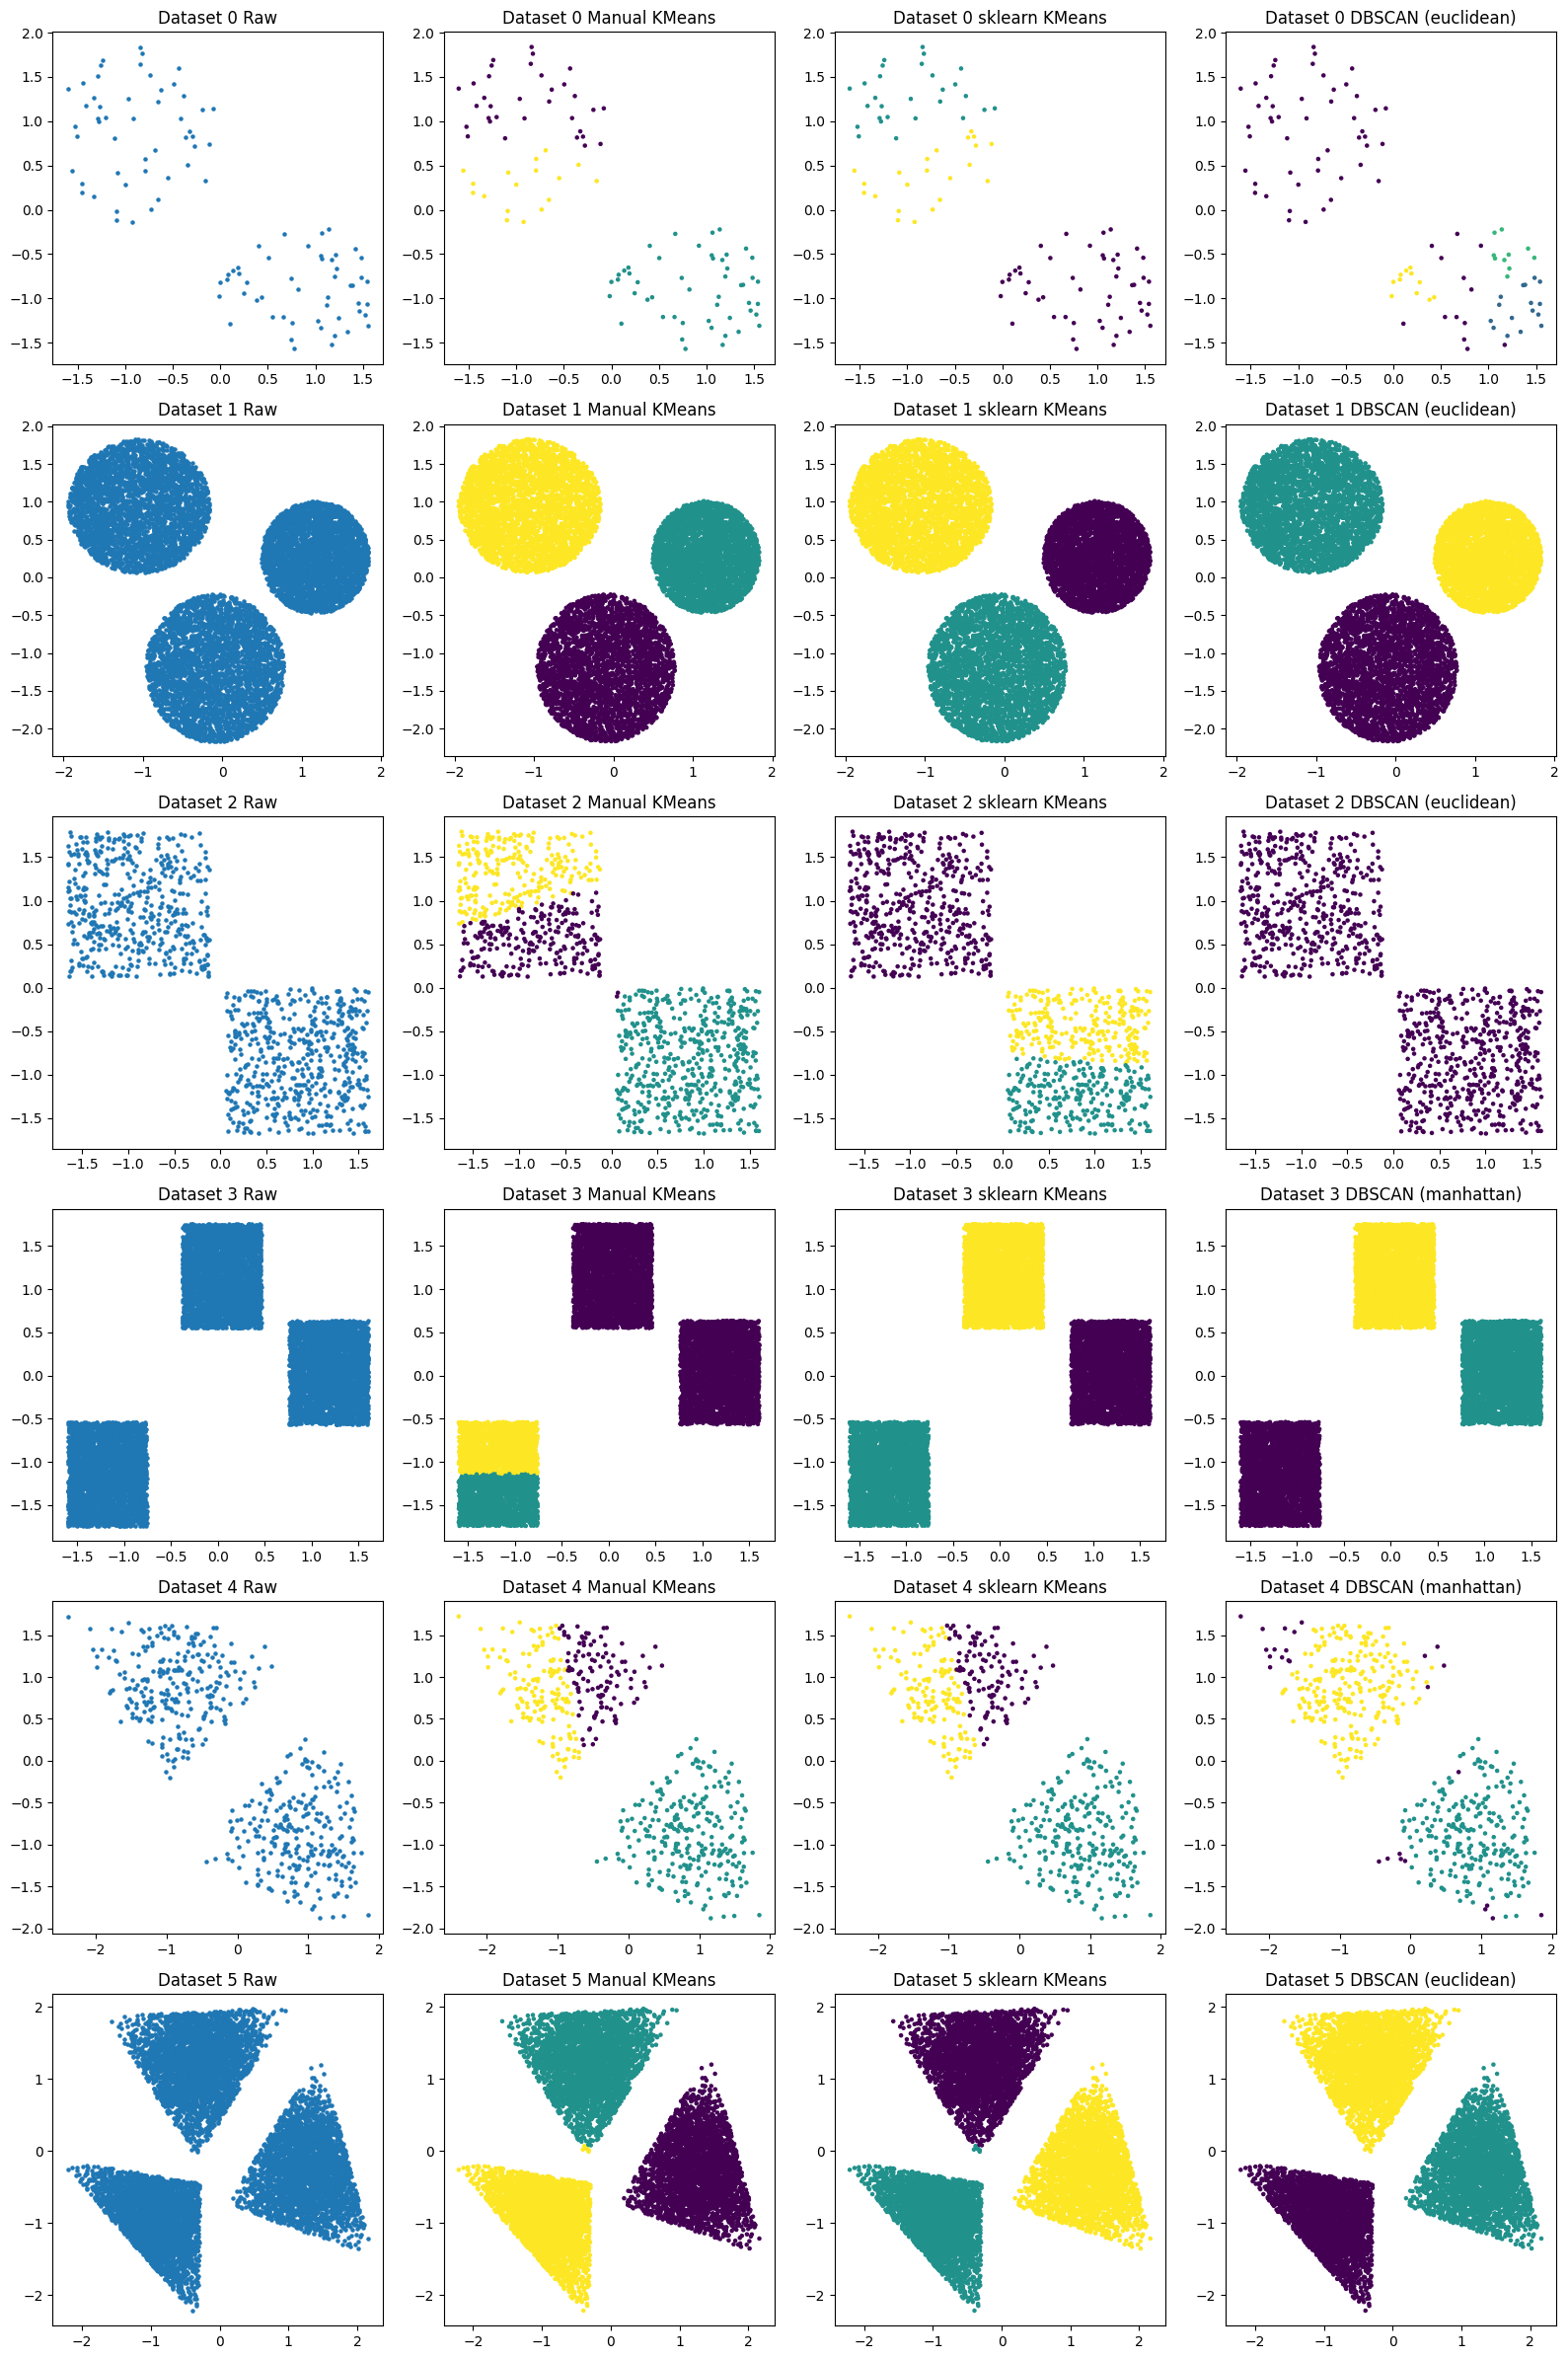

In [63]:
# ========================
# Настройки
# ========================
N_CLUSTERS = 3
FILES = [f"{i}.xlsx" for i in range(6)]

# ========================
# Загрузка Excel файлов
# ========================
datasets = []

for filename in FILES:
    df = pd.read_excel(filename)
    X = df.iloc[:, :2].values
    datasets.append(X)

# ========================
# Ручной K-Means (простая реализация)
# ========================
def manual_kmeans(X, k, max_iter=100):
    rng = np.random.default_rng(42)
    centers = X[rng.choice(len(X), k, replace=False)]

    for _ in range(max_iter):
        dist = cdist(X, centers)
        labels = np.argmin(dist, axis=1)

        new_centers = np.array([
            X[labels == i].mean(axis=0) if np.any(labels == i) else centers[i]
            for i in range(k)
        ])

        if np.allclose(centers, new_centers):
            break

        centers = new_centers

    return labels, centers

# ========================
# Поиск медоида
# ========================
def find_medoid(points, metric="euclidean"):
    scipy_metric = "cityblock" if metric == "manhattan" else metric
    dist = cdist(points, points, metric=scipy_metric)
    return points[np.argmin(dist.sum(axis=1))]

# ========================
# Визуализация
# ========================
plot_num = 1
plt.figure(figsize=(16, 24))

for i, X in enumerate(datasets):

    # ========================
    # Метрика расстояния
    # ========================
    metric = "manhattan" if i in [3, 4] else "euclidean"

    # Нормализация
    X_scaled = StandardScaler().fit_transform(X)

    # ========================
    # 1. Исходные точки
    # ========================
    plt.subplot(len(datasets), 4, plot_num)
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], s=5)
    plt.title(f"Dataset {i} Raw")
    plot_num += 1

    # ========================
    # 2. Ручная кластеризация
    # ========================
    labels_manual, centers_manual = manual_kmeans(X_scaled, N_CLUSTERS)

    plt.subplot(len(datasets), 4, plot_num)
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_manual, s=5)
    plt.title(f"Dataset {i} Manual KMeans")
    plot_num += 1

    # ========================
    # 3. sklearn KMeans
    # ========================
    kmeans = cluster.KMeans(n_clusters=N_CLUSTERS, n_init=10)
    labels_kmeans = kmeans.fit_predict(X_scaled)

    plt.subplot(len(datasets), 4, plot_num)
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_kmeans, s=5)
    plt.title(f"Dataset {i} sklearn KMeans")
    plot_num += 1

    # ========================
    # 4. DBSCAN
    # ========================
    dbscan = cluster.DBSCAN(eps=0.3, min_samples=10, metric=metric)
    labels_dbscan = dbscan.fit_predict(X_scaled)

    plt.subplot(len(datasets), 4, plot_num)
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_dbscan, s=5)
    plt.title(f"Dataset {i} DBSCAN ({metric})")
    plot_num += 1

    # ========================
    # Медоиды и центры
    # ========================
    print(f"\nDataset {i}")

    labels_used = labels_kmeans
    unique_labels = [l for l in np.unique(labels_used) if l != -1]

    centers = []

    for lbl in unique_labels:
        cluster_points = X_scaled[labels_used == lbl]

        medoid = find_medoid(cluster_points, metric)
        center = cluster_points.mean(axis=0)

        centers.append(center)

        print(f"Cluster {lbl}")
        print("Medoid:", medoid)
        print("Center:", center)

    if centers:
        avg_center = np.mean(centers, axis=0) * 1000
        print("Average centers * 1000:", avg_center)

plt.tight_layout()
plt.show()
